Simulation goals

* Categorical response variable

* Different feature distribution for different domains

Simulation

* $D$: total number of features

* $d_{1}$: number of features with higher frequency in a domain 1

* $d_{2}$: number of features with higher frequency in a domain 2


* $d_{1} \sim \operatorname{Unif}(0, \lfloor D/4 \rfloor)$

* $d_{2} \sim \operatorname{Unif}(0, \lfloor D/4 \rfloor)$ ($d_{1} + d_{2} \le D$)

* $k \in [D]$ for indexing feature

* Let $\Delta_{r} = \{j \in [D]: \textrm{feature } j \textrm{ is more frequent in a domain } r \}$

* Sample $\Delta_{1} \subseteq [D]$ such that $|\Delta_{1}| = d_{1}$ 

* Sample $\Delta_{2} \subseteq [D]\backslash \Delta_{1}$ such that $|\Delta_{2}| = d_{2}$

* Let $\alpha_{1} \overset{\Delta}{=} \left( \alpha_{11}, \ldots, \alpha_{1D} \right)$ be a feature frequency vector for a domain 1

* Let $\alpha_{2} \overset{\Delta}{=} \left( \alpha_{21}, \ldots, \alpha_{2D} \right)$ be a feature frequency vector for a domain 2


* For each $k \in [D]$: 

    * If $k \in \Delta_{1}$, $\alpha_{1k} > \alpha_{2k}$

    * If $k \in \Delta_{2}$, $\alpha_{2k} > \alpha_{1k}$

    * Otherwise $\alpha_{1k} = \alpha_{2k}$


* Sample $\rho_{1} \sim \operatorname{Dir}(\alpha_{1})$

* Sample $\rho_{2} \sim \operatorname{Dir}(\alpha_{2})$

* Sample a code-specific contribution to mortality: $W_{i} \sim   \mathcal{N}\!\left(0,1\right)$

* For each patient $i$ in a domain $r$

    * $\tilde{X}_{i} \sim \operatorname{Multi}(n_{i}; \rho_{r})$ where $\tilde{X}_{i}$ is a vector of counts for each diagnosis code/feature, $n_i = 3k$.

	* We set $X_{ik} = \min \left\{ \tilde{X}_{ik}, 1 \right\}$ where $\tilde{X}_{ik}$ is a count for a diagnosis code/feature $k$, $k \in [D]$

* For all patient $i$ in a domain $r$

    * $b = -\operatorname{Mean}(\sum_{k} W_{k} X_{ik})$

* For each patient $i$ in a domain $r$

	* pathogenic score $\bar{p}_{i} = \operatorname{sigmoid}(\sum_{k} W_{k} X_{ik} + b)$ (aka a liability model)

    <!-- * If $\bar{p}_{i} \ge 0.5, Y_{i} = 1$; else $Y_{i} = 0$. -->

	* Sample $Y_{i} \sim \operatorname{Bern}(\bar{p}_{i})$

    * Alternatively, if $\bar{p}_{i} \ge 0.5, Y_{i} = 1$; otherwise, $Y_{i} = 0$

In [11]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")

from common import *
from deep_patient.sda import SDA
from math import floor, exp, ceil
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import dirichlet
import ot
import pandas as pd
from random import randint
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

base_dir = "/home/wanxinli/deep_patient"

In [12]:
""" 
Simulation scheme
"""

def simulate(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme

    TODO: reconsider the choice of alpha_1 and alpha_2

    :return
        list[list[int]] domain 1 features
        list[int] domain 1 labels
        list[list[int]] domain 2 features
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    delta_1 = np.random.choice(size = d_1, a = range(1, D+1), replace=False)
    remaining_set = list(set(list(range(1, D+1)))-set(delta_1))
    delta_2 = np.random.choice(size = d_1, a = remaining_set, replace=False)
    
    unit_1 = 1/(2*d_1-2*d_2+3*D)
    alpha_1 = [5*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([3*unit_1]*(D-d_1-d_2))
  
    unit_2 = 1/(-2*d_1+2*d_2+3*D)
    alpha_2 = [unit_2]*d_1
    alpha_2.extend([5*unit_2]*d_2)
    alpha_2.extend([3*unit_2]*(D-d_1-d_2))  

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]
        W = np.random.normal(size=D)
        W = [abs(W_k) for W_k in W] # only sample positive weights
        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(len(rho), rho)
            for k in range(len(X_i)):
                if X_i[k] > 0:
                    X_i[k] = 1 # dominant effect
            X.append(X_i)
            cur_sum = np.sum(np.multiply(W, X_i))
            all_sum.append(cur_sum)
        
        print("all_sum before preprocessing is:", all_sum)
        # standardize
        all_sum = preprocessing.scale(all_sum)
        print("all_sum after preprocessing is:", all_sum)

        all_sum = np.array(all_sum)
        
        P = []
        for cur_sum in all_sum:
            p_i = sigmoid(cur_sum)
            P.append(p_i)
            Y_i = 0
            if p_i >= 0.5: # TODO: mimic exact logistic regression, change to np.random.binomial later
                Y_i = 1
            # Y_i = np.random.binomial(1, p_i) # too much noise, domain 1 data cannot learn well
            Y.append(int(Y_i))
        print("P is:", P)

            
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    
    def pad_features(features_list):
        """ 
        Pad features to the same length (maximum length of the original features)\
            in each domain by -1
        """
        max_len = 0
        for features in features_list:
            max_len = max(max_len, len(features))

        for i in range(len(features_list)):
            features_list[i] += [-1] * (max_len - len(features_list[i]))
        return features_list



    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    feature_1 = pad_features(feature_vector_to_feature(feature_vector_1))
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    feature_2 = pad_features(feature_vector_to_feature(feature_vector_2))
    return np.array(feature_1), label_1, np.array(feature_2), label_2



In [13]:
""" 
Wrapper function with different set ups for simulate()
"""
def simulate_wrapper(num_patient):
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate(D, d_1, d_2, num_patient)

In [14]:
"""
Train deep patient model and generate representations for males and females
"""

def custom_train_reps(male_seqs, female_seqs):
    """ 
    Customized training algorithm for generating male representations and female representations
    
    :returns: male representations, female representations
    """

    # customized parameters
    nhidden = 3
    nlayer = 1

    # for males
    # initiate the model
    male_sda = SDA(male_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 100,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    male_sda.train(male_seqs)

    # apply the mode
    male_reps = male_sda.apply(male_seqs)

    # for females
    # initiate the model
    female_sda = SDA(female_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 100,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    female_sda.train(female_seqs)

    # apply the mode
    female_reps = female_sda.apply(female_seqs)
    return male_reps, female_reps


In [15]:
def plot_scatter(male_reps, male_labels, female_reps, female_labels, trans_female_reps, title):
    male_1 = [i for i, x in enumerate(male_labels) if x == 1]
    male_0 = [i for i, x in enumerate(male_labels) if x == 0]
    female_1 = [i for i, x in enumerate(female_labels) if x == 1]
    female_0 = [i for i, x in enumerate(female_labels) if x == 0]

    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(projection='3d')
    ax.scatter(male_reps[male_0,0], male_reps[male_0,1], male_reps[male_0,2], color='red', label="male 0", alpha=0.5, facecolors='none', s=130)
    ax.scatter(male_reps[male_1,0], male_reps[male_1,1], male_reps[male_1,2], color='red', label="male 1", alpha=0.5, marker="x", s=130)

    ax.scatter(female_reps[female_0,0], female_reps[female_0,1], female_reps[female_0,2], color='blue', label="female 0", alpha=0.5, facecolors='none', s=100)
    ax.scatter(female_reps[female_1,0], female_reps[female_1,1], female_reps[female_1,2], color='blue', label="female 1", alpha=0.5, marker="x", s=100)

    ax.scatter(trans_female_reps[female_0,0], trans_female_reps[female_0,1], trans_female_reps[female_0,2], color='green', label="trans female 0",  alpha=0.5, facecolors='none', s=70)
    ax.scatter(trans_female_reps[female_1,0], trans_female_reps[female_1,1], trans_female_reps[female_1,2], color='green', label="trans female 1",  alpha=0.5, marker="x", s=70)

    plt.title(title)
    plt.legend()
    plt.show()


In [16]:
def plot_scatter_opp(male_reps, male_labels, female_reps, female_labels, trans_male_reps, title):
    male_1 = [i for i, x in enumerate(male_labels) if x == 1]
    male_0 = [i for i, x in enumerate(male_labels) if x == 0]
    female_1 = [i for i, x in enumerate(female_labels) if x == 1]
    female_0 = [i for i, x in enumerate(female_labels) if x == 0]

    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(projection='3d')
    ax.scatter(male_reps[male_0,0], male_reps[male_0,1], male_reps[male_0,2], color='red', label="male 0", alpha=0.5, facecolors='none', s=70)
    ax.scatter(male_reps[male_1,0], male_reps[male_1,1], male_reps[male_1,2], color='red', label="male 1", alpha=0.5, marker="x")

    ax.scatter(female_reps[female_0,0], female_reps[female_0,1], female_reps[female_0,2], color='blue', label="female 0", alpha=0.5, facecolors='none', s=70)
    ax.scatter(female_reps[female_1,0], female_reps[female_1,1], female_reps[female_1,2], color='blue', label="female 1", alpha=0.5, marker="x")

    ax.scatter(trans_male_reps[male_0,0], trans_male_reps[male_0,1], trans_male_reps[male_0,2], color='green', label="trans male 0",  alpha=0.5, facecolors='none', s=70)
    ax.scatter(trans_male_reps[male_1,0], trans_male_reps[male_1,1], trans_male_reps[male_1,2], color='green', label="trans male 1",  alpha=0.5, marker="x")

    plt.title(title)
    plt.legend()
    plt.show()


In [17]:
male_accuracies, male_precisions, male_recalls, male_f1s, \
    female_accuracies, female_precisions, female_recalls, female_f1s, \
    trans_female_accuracies, trans_female_precisions, trans_female_recalls, trans_female_f1s = \
    run_proc_multi(simulate_wrapper, custom_train_reps, svm.SVC , n_times = 100)

all_sum before preprocessing is: [1.5210423872630612, 2.4724675526854654, 1.5210423872630612, 2.4724675526854654, 1.6395202017053598, 1.6395202017053598, 2.4724675526854654, 2.4724675526854654, 1.5210423872630612, 0.6880950362829557, 1.5210423872630612, 2.4724675526854654, 1.5210423872630612, 1.5210423872630612, 2.4724675526854654, 1.5210423872630612, 1.6395202017053598, 2.4724675526854654, 2.4724675526854654, 1.6395202017053598, 1.6395202017053598, 1.5210423872630612, 1.6395202017053598, 1.6395202017053598, 1.6395202017053598, 1.5210423872630612, 1.9077971901422925, 1.5210423872630612, 2.4724675526854654, 1.6395202017053598, 2.4724675526854654, 2.4724675526854654, 2.4724675526854654, 2.4724675526854654, 1.6395202017053598, 0.6880950362829557, 1.6395202017053598, 1.6395202017053598, 2.4724675526854654, 2.4724675526854654, 1.5210423872630612, 0.6880950362829557, 1.6395202017053598, 2.4724675526854654, 2.4724675526854654, 2.4724675526854654, 1.5210423872630612, 1.5210423872630612, 2.4724

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.394
(*) epoch 2, cost 2.513
(*) epoch 3, cost 1.743
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 3
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.151
(*) epoch 2, cost 1.126
(*) epoch 3, cost 0.714
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
exception 2
all_sum before preprocessing is: [1.0567551984937367, 3.066672306509857, 3.066672306509857, 3.066672306509857, 1.0567551984937367, 3.066672306509857, 3.066672306509857, 4.93315667417481, 3.066672306509857, 3.066672306509857, 1.0567551984937367, 3.066672306509857, 1.0567551984937367, 3.066672306509857, 2.4996331328832033, 1.0567551984937

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 2.152
(*) epoch 2, cost 1.586
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [2.7376491739021613, 2.6440546583580913, 3.2191033247654293, 2.07036472900332, 2.6440546583580913, 2.925175268470923, 3.1140601000922516, 2.7170396701825172, 2.7170396701825172, 3.4272389230538347, 2.6440546583580913, 2.83293948997942, 2.925175268470923, 2.07036472900332, 3.3113391032569326, 3.4272389230538347, 2.7170396701825172, 2.6440546583580913, 2.6440546583580913, 2.83293948997942, 1.7571859060417365, 2.6440546583580913, 3.634171982297645, 1.7709421978271478, 3.0302184931441007, 2.435919060069686, 3.7083595331666666, 2.330875835396508, 2.8509877176019014, 2.7376491739021613, 2.925175268470923, 3.0302184931441007, 2.435919060069686, 2.435919060069686, 1.678706419335645, 2.0497552252836764, 2.83293948997942, 2.6440546583580913, 3.1346696038118953, 3.4260363840092394, 3.1140601000922516, 2.435919060

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 2.290
(*) epoch 2, cost 1.588
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
exception 2
all_sum before preprocessing is: [2.184568981693325, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 2.6003771844927615, 2.184568981693325, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 2.184568981693325, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 1.2907313835705914, 2.184568981693325, 1.2907313835705914, 1.2907313835705914, 1.3227834268071

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.370
(*) epoch 2, cost 3.483
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.9887909831164197, 3.0782050440589495, 1.5348641421403246, 1.9887909831164197, 4.273911149664357, 1.9887909831164197, 1.5348641421403246, 1.5348641421403246, 3.819984308688262, 1.5348641421403246, 1.5348641421403246, 1.9887909831164197, 1.9887909831164197, 1.9887909831164197, 1.9887909831164197, 1.5348641421403246, 1.5348641421403246, 1.9887909831164197, 1.5348641421403246, 3.532131885035045, 4.273911149664357, 1.9887909831164197, 5.363325210606887, 1.9887909831164197, 1.9887909831164197, 3.0782050440589495, 1.9887909831164197, 1.5348641421403246, 3.819984308688262, 4.273911149664357, 4.273911149664357, 1.9887909831164197, 1.5348641421403246, 4.273911149664357, 1.5348641421403246, 1.5348641421403246, 1.5348641421403246, 1.5348641421403246, 1.9887909831164197, 1.9887909831164197, 1.9887909831164197, 1

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.136
(*) epoch 2, cost 3.512
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 2.294811406192574, 0.23433638184985547, 1.4569329328081078, 3.5056987590817634, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 3.3215748448050846, 1.4569329328081078, 1.4569329328081078, 1.8707723304294395, 3.5056987590817634, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 1.4569329328081078, 3.5056987590817634, 2.294811406192574, 3.5056987590817634, 1.4569329328081078, 1.4569329328081078, 3.5056987590817634, 2.294811406192574, 1.4569329328081078, 2.294811406192574, 0.23433638184985547, 1.4569329328081078, 1.456932932808

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 2.947
(*) epoch 2, cost 2.036
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [2.839068548360105, 2.839068548360105, 2.241088724421753, 3.91528744229521, 2.839068548360105, 3.3755543735220526, 2.3613196216565098, 4.339071087033834, 2.8978054468184573, 2.3613196216565098, 2.7188376511253485, 2.3613196216565098, 2.3613196216565098, 2.839068548360105, 2.241088724421753, 2.3613196216565098, 2.3613196216565098, 2.8978054468184573, 2.839068548360105, 2.7775745495837008, 2.3613196216565098, 2.7188376511253485, 4.81682001373743, 1.4597870502142902, 2.241088724421753, 2.839068548360105, 2.7188376511253485, 2.3613196216565098, 3.6211494719884656, 1.9375359769178857, 2.3613196216565098, 2.839068548360105, 2.839068548360105, 2.241088724421753, 4.81682001373743, 2.7188376511253485, 2.839068548360105, 2.7188376511253485, 2.7188376511253485, 2.241088724421753, 2.3613196216565098, 2.36131962165

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.139
(*) epoch 2, cost 3.264
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.577
(*) epoch 2, cost 2.154
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.173823053644946, 1.173823053644946, 3.23827957985314, 1.173823053644946, 3.23827957985314, 1.173823053644946, 1.173823053644946, 3.23827957985314, 1.173823053644946, 3.23827957985314, 1.173823053644946, 1.173823053644946, 1.173823053644946, 3.23827957985314, 1.173823053644946, 2.3346487301345555, 1.173823053644946, 1.173823053644946, 3.23827957985314, 1.173823

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 4.402
(*) epoch 2, cost 2.442
(*) epoch 3, cost 1.761
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [3.212926171393872, 4.268130732520237, 3.5017030392611628, 3.8466104255522793, 3.8466104255522793, 3.8466104255522793, 3.8466104255522793, 3.8466104255522793, 3.080182732293206, 3.8466104255522793, 3.8466104255522793, 4.268130732520237, 3.8466104255522793, 2.355655861619912, 2.355655861619912, 3.8466104255522793, 4.268130732520237, 3.8466104255522793, 3.5017030392611628, 3.080182732293206, 4.268130732520237, 3.8466104255522793, 3.8466104255522793, 4.268130732520237, 2.0107484753287954, 3.8466104255522793, 1.5892281683608385, 3.080182732293206, 2.355655861619912, 3.8466104255522793, 3.8466104255522793, 3.080182732293206, 4.268130732520237, 4.268130732520237, 2.777176168587869, 3.5017030392611628, 2.355655861619912, 4.268130732520237, 3.080182732293206, 4.268130732520237, 1.589228

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.132
(*) epoch 2, cost 2.456
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.457
(*) epoch 2, cost 1.966
(*) training time: 0.00 sec.

training time: 0.26 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [5.110458655045474, 6.10552784484784, 3.9680951610428115, 4.975478875122955, 4.10307494096533, 6.171015713188009, 5.7318149523115975, 4.242858958150938, 4.28459098003693, 4.817039498949868, 5.6846391958444045, 7.4595040590859805, 5.7318149523115975, 3.3939146202438812, 3.621502660884815, 7.4595040590859805, 4.419570759959449, 6.380291641955968, 4.88287061440454, 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 2.143
(*) epoch 2, cost 1.359
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 7
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.531
(*) epoch 2, cost 3.838
(*) epoch 3, cost 3.246
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.159054452068188, 1.159054452068188, 1.159054452068188, 1.8388856571707497, 1.685850696586499, 1.685850696586499, 1.685850696586499, 1.159054452068188, 1.685850696586499, 1.685850696586499, 1.685850696586499, 1.685850696586499, 1.159054452068188, 1.159054452068188, 1.159054452068188, 1.685850696586499, 1.8388856571707497, 1.6858506965864

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 5.998
(*) epoch 2, cost 4.642
(*) epoch 3, cost 3.992
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 1.9354853399440937, 3.386198272418634, 3.386198272418634, 1.9354853399440937, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 3.386198272418634, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 3.386198272418634, 1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 3.386198272418634, 1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 3.386198272418634, 1.9354853399440937, 1.9354853399440937, 1.9354853399440937, 0.7078061864843456, 1.9354853399440937, 1.935485339944

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 5.310
(*) epoch 2, cost 2.461
(*) epoch 3, cost 2.153
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 3
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.496
(*) epoch 2, cost 1.275
(*) epoch 3, cost 0.799
(*) training time: 0.00 sec.

training time: 0.27 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.1515228822646053, 1.15152288226460

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 5.879
(*) epoch 2, cost 3.617
(*) epoch 3, cost 2.565
(*) epoch 4, cost 2.316
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.001
(*) epoch 2, cost 2.183
(*) training time: 0.00 sec.

training time: 0.29 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.0773079700323993, 0.40733643105940315, 1.9593259519185429, 2.3226256157286223, 2.419165124423936, 1.9593259519185429, 1.9593259519185429, 2.9925971547016186, 0.6174687975270061, 2.9925971547016186, 0.6174687975270061, 2.629297490891539, 0.6174687975270061, 1.0773079700323993, 1.9593259519185429, 0.883092619702349

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 2.770
(*) epoch 2, cost 1.551
(*) epoch 3, cost 1.100
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [0.7954913398328961, 1.3970923415251457, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 1.1218893865998663, 1.3970923415251457, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 0.7954913398328961, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.3970923415251457, 1.3970923415251457, 0.7954913398328961, 1.3970923415251457, 0.7954913398328961, 0.7954913398328961, 1.397092

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 5.637
(*) epoch 2, cost 2.068
(*) epoch 3, cost 1.093
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 7
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 6.312
(*) epoch 2, cost 3.817
(*) epoch 3, cost 3.083
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [5.444900986994079, 5.5102606984280875, 2.4314992687084334, 4.252567576950161, 5.444900986994079, 4.252567576950161, 4.252567576950161, 1.7032743120960405, 2.4314992687084334, 2.4314992687084334, 5.444900986994079, 4.252567576950161, 3.524342620337768, 3.9600033312447795, 4.252567576950161, 4.252567576950161, 2.4314

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.520
(*) epoch 2, cost 3.164
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.523
(*) epoch 2, cost 3.081
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [3.2892641821661304, 5.183065510826967, 2.785292980518671, 4.822558042098631, 5.687036712474427, 5.687036712474427, 4.793515434346311, 2.785292980518671, 3.2892641821661304, 3.2892641821661304, 4.822558042098631, 4.822558042098631, 4.793515434346311, 3.2892641821661304, 3.2892641821661304, 4.822558042098631, 3.145800449247008, 3.2892641821661304, 2.78529298051867

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


(*) epoch 1, cost 9.591
(*) epoch 2, cost 5.568
(*) epoch 3, cost 3.827
(*) epoch 4, cost 3.320
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
exception 1
all_sum before preprocessing is: [1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 2.2305350085109135, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 2.2305350085109135, 2.2569547872000584, 2.2305350085109135, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 1.1997490577297196, 1.8151892030742243, 1.8151892030742243, 2.6723005926367476, 1.8151892030742243, 1.8151892030742243, 1.8151892030742243, 2.2305350085109135, 2.2305350085109135, 1.8151892030742243, 2.2305350085109135, 2.2305350085109135, 1.8151892030742243, 1.8151892030742243, 2.2305350085109135, 1.8151892030

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.733
(*) epoch 2, cost 2.429
(*) epoch 3, cost 1.966
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 7.874
(*) epoch 2, cost 4.361
(*) epoch 3, cost 2.877
(*) epoch 4, cost 2.383
(*) training time: 0.00 sec.

training time: 0.27 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.8388922579774296, 1.8388922579774296, 1.311879903104161, 1.311879903104161, 1.611418367713973, 1.611418367713973, 1.8388922579774296, 1.311879903104161, 1.311879903104161, 1.611418367713973, 1.311879903104161, 1.8388922579774296, 1.8388922579774296, 1.8388922579774296, 1.311879903104161, 2

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.479
(*) epoch 2, cost 3.135
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [3.4245577306657893, 5.73804539056515, 5.27586884514397, 3.4245577306657893, 3.4245577306657893, 5.086100074080345, 3.4245577306657893, 3.886734276086969, 5.935507550598334, 5.27586884514397, 6.207915324955889, 3.886734276086969, 5.73804539056515, 3.4245577306657893, 5.73804539056515, 6.397684096019514, 5.548276619501524, 6.609734917559143, 5.27586884514397, 3.4245577306657893, 5.73804539056515, 5.9727259635278545, 5.745738779534709, 4.601683186252909, 5.27586884514397, 4.084196436120154, 3.886734276086969, 4.546372981541333, 5.294890534145926, 3.2347889596021644, 3.4245577306657893, 5.935507550598334, 7.149851419114974, 5.27586884514397, 3.4617761435953094, 4.171818892474801, 3.886734276086969, 5.548276619501524, 5.99081775530991, 3.886734276086969, 5.73804539056515, 3.886734276086969, 5.2758688451439

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.416
(*) epoch 2, cost 2.450
(*) training time: 0.00 sec.

training time: 0.29 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 8
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 5.827
(*) epoch 2, cost 4.842
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [4.053290186916592, 3.750168965353423, 3.4617931038962024, 4.053290186916592, 3.4617931038962024, 3.4617931038962024, 3.750168965353423, 4.053290186916592, 3.750168965353423, 3.4617931038962024, 3.4617931038962024, 3.4617931038962024, 4.1676553441038005, 3.4617931038962024, 3.750168965353423, 3.750168965353423, 2.059197339460349, 4.332415090542197, 3.764914325459

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.839
(*) epoch 2, cost 2.601
(*) epoch 3, cost 2.161
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 5
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 3.392
(*) epoch 2, cost 2.515
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
exception 2
all_sum before preprocessing is: [1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.4185563704460222, 1.418556

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 1.604
(*) epoch 2, cost 1.124
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 6
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 2.947
(*) epoch 2, cost 2.656
(*) training time: 0.00 sec.

training time: 0.27 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [4.749469375826298, 3.8582176218230146, 3.8582176218230146, 5.131563965754261, 2.524109896677278, 2.524109896677278, 3.8582176218230146, 4.240312211750979, 6.84780409781425, 4.749469375826298, 5.322365423202797, 5.322365423202797, 4.749469375826298, 4.622444618665231, 4.749469375826298, 3.731192864661948, 3.8582176218230146, 1.6328581426739954, 2.524109896677278,

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 0.629
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [3.5784446678549515, 3.5784446678549515, 0.8445279586129131, 1.6452509797479853, 2.2055742827911615, 1.6452509797479853, 4.3381391697278335, 2.7777216467198795, 1.6452509797479853, 2.2055742827911615, 3.5784446678549515, 1.6452509797479853, 4.138767970898128, 1.6452509797479853, 0.8445279586129131, 4.138767970898128, 1.6452509797479853, 1.6452509797479853, 3.5784446678549515, 1.6452509797479853, 1.6452509797479853, 1.6452509797479853, 1.6452509797479853, 1.6452509797479853, 1.6452509797479853, 0.8445279586129131, 0.8445279586129131, 4.138767970898128, 1.6452509797479853, 1.6042224604857949, 2.404945481620867, 3.5784446678549515, 1.6452509797479853, 2.2055742827911615, 1.4048512616560895, 4.097739451635937, 3.3380449497630558, 1.6452509797479853, 1.6452509797479853, 2.2055742827911615, 1.6452509797479853, 3.5784446678549515, 2

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.879
(*) epoch 2, cost 3.684
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [2.6185483712222393, 1.4602059813295853, 2.4481244055958915, 2.6185483712222393, 0.8047557378003511, 2.4481244055958915, 2.614515155155544, 2.4481244055958915, 2.4481244055958915, 2.4481244055958915, 0.9751797034266988, 2.1335220933193524, 2.929117467432083, 2.4481244055958915, 1.9630981276930048, 1.9630981276930048, 2.4481244055958915, 1.2897820157032378, 1.4602059813295853, 5.066358401314782, 2.4481244055958915, 1.9630981276930048, 1.4602059813295853, 1.2897820157032378, 1.9630981276930048, 2.6185483712222393, 0.8047557378003511, 2.1335220933193524, 2.4481244055958915, 2.4481244055958915, 2.614515155155544, 1.2897820157032378, 2.4481244055958915, 2.6185483712222393, 2.4481244055958915, 1.2897820157032378, 2.1335220933193524, 2.6185483712222393, 2.4481244055958915, 2.6185483712222393, 2.61854837122223

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.025
(*) epoch 2, cost 2.672
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 1.810
(*) epoch 2, cost 1.505
(*) training time: 0.00 sec.

training time: 0.17 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [2.0427455866818716, 2.384075731248773, 2.384075731248773, 1.3357805722407605, 1.3357805722407605, 1.3357805722407605, 0.7527935523635318, 1.458102313981212, 0.6304718106230803, 1.3357805722407605, 0.7527935523635318, 1.458102313981212, 1.3357805722407605, 1.458102313981212, 1.3357805722407605, 1.3357805722407605, 0.6304718106230803, 1.3357805722407605, 1.4581023

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 3.484
(*) epoch 2, cost 2.760
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [1.9462220925771694, 2.392161169055967, 3.0060673908340436, 3.0060673908340436, 3.363942658427741, 2.392161169055967, 2.560128314355246, 3.5710445777262376, 2.560128314355246, 2.560128314355246, 2.1850592497574706, 2.560128314355246, 3.739011723025517, 3.12510550124744, 2.560128314355246, 2.560128314355246, 2.392161169055967, 3.739011723025517, 3.363942658427741, 3.0060673908340436, 3.739011723025517, 1.9462220925771694, 3.0060673908340436, 1.9462220925771694, 2.392161169055967, 2.0170921044581913, 2.392161169055967, 3.12510550124744, 3.0060673908340436, 2.392161169055967, 3.5720625893794633, 2.392161169055967, 2.630998326236268, 2.560128314355246, 2.1850592497574706, 1.5711530279793937, 3.12510550124744, 2.560128314355246, 2.560128314355246, 2.1850592497574706, 1.9462220925771694, 3.5710445777262376, 

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(*) epoch 1, cost 5.733
(*) epoch 2, cost 4.655
(*) epoch 3, cost 4.315
(*) training time: 0.00 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 4
(*) no. of hidden units: 3
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 100

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 4.092
(*) epoch 2, cost 2.509
(*) epoch 3, cost 1.841
(*) training time: 0.00 sec.

training time: 0.16 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
all_sum before preprocessing is: [5.3908759696512405, 5.445352141233309, 4.832767999828466, 5.3908759696512405, 4.840996038619031, 2.7117451741916634, 4.9635317021862075, 5.445352141233309, 4.832767999828466, 4.832767999828466, 4.832767999828466, 4.832767999828466, 4.832767999828466, 5.445352141233309, 5.445352141233309, 4.832767999828466, 4.832767

/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wanxinli/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
score_path = "../outputs/sim1_svm_scores.csv"
save_scores(male_accuracies, male_precisions, male_recalls, male_f1s, \
        female_accuracies, female_precisions, female_recalls, female_f1s, \
        trans_female_accuracies, trans_female_precisions, trans_female_recalls, trans_female_f1s, score_path)

average trans female to female accuracy increment is 2.7%
median trans female to female accuracy increment is 0.0%
average trans female to female accuracy f1 is 6.4%
median trans female to female accuracy f1 is 0.0%


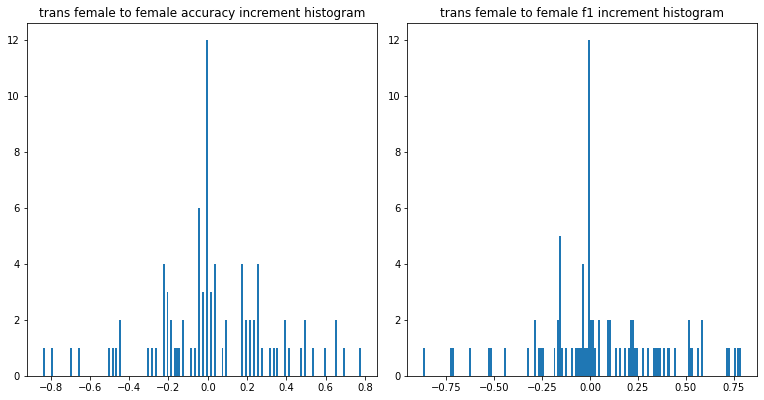

In [19]:
""" 
Larger is better (>0)
"""
hist_plot(score_path, filter=False)

average trans female to female accuracy increment is 10.1%
median trans female to female accuracy increment is 2.0%
average trans female to female accuracy f1 is 14.9%
median trans female to female accuracy f1 is 4.0%


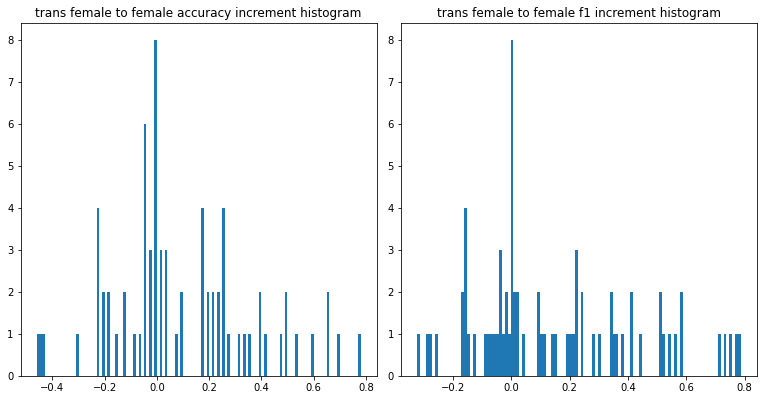

In [20]:
""" 
female accuracy > 0.7 filtered out 
"""

hist_plot(score_path, filter=True)